# Exploratory Analysis
#### Brian Bahmanyar

***

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import *
import seaborn as sns

import statsmodels.api as sm

from helpers import *
from plots import *

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%matplotlib inline
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon': True,
                            'axes.labelsize': 'small'})
#sns.set_context("talk")

In [3]:
tech = pd.read_csv('tech_bundle.csv', index_col=0)
tech.index = pd.to_datetime(tech.index)

In [4]:
def plot_stocks(index, stocks, labels, positions=None, label_annually=True):
    """
    Plots up to 5 stocks
    
    Args:
        index (DateTimeIndex): date range
        stocks (list): list of stocks to plot
        labels (list): labels to use for plotting
        positions (list of dicts): optional postions to overplot
        label_annually (boolean): plots x label monthly if false, annually otherwise
        
    Returns (None): Will output plot inline
    """
    colors = ['firebrick','steelblue','orange','mediumorchid', 'mediumseagreen']
    
    fig, ax = plt.subplots(figsize=(20,8));
    
    if label_annually:
        span = YearLocator();
        my_format = DateFormatter('%Y');
    else:
        span = MonthLocator();
        my_format = DateFormatter('%b %Y');    
    
    ax.xaxis.set_major_locator(span);
    ax.xaxis.set_major_formatter(my_format);
    ax.autoscale_view();
    
    plt.title('Adjusted Close Prices', fontsize=20);
    plt.ylabel('Adj. Close', fontsize=15);
    plt.xlabel('Time', fontsize=15);
    
    for stock, label, color in zip(stocks, labels, colors):
        ax.plot_date(index, stock, color=color, linestyle='-', marker=None, label=label);
        plt.xticks(rotation=45)
    
    if positions:
        for position in positions:
            ax.axvline(df.index[position['open']], color='lime', linestyle='-')
            ax.axvline(df.index[position['close']], color='red', linestyle='-')
 
    plt.legend(loc=2, prop={'size':15}, frameon=True);

Exploring trend and randomness of the prices over time: 

In [5]:
tech.columns

Index(['AAPL', 'AAPL/FB', 'AMZN', 'AMZN/AAPL', 'AMZN/FB', 'FB', 'ln(AAPL)',
       'ln(AMZN)', 'ln(FB)'],
      dtype='object')

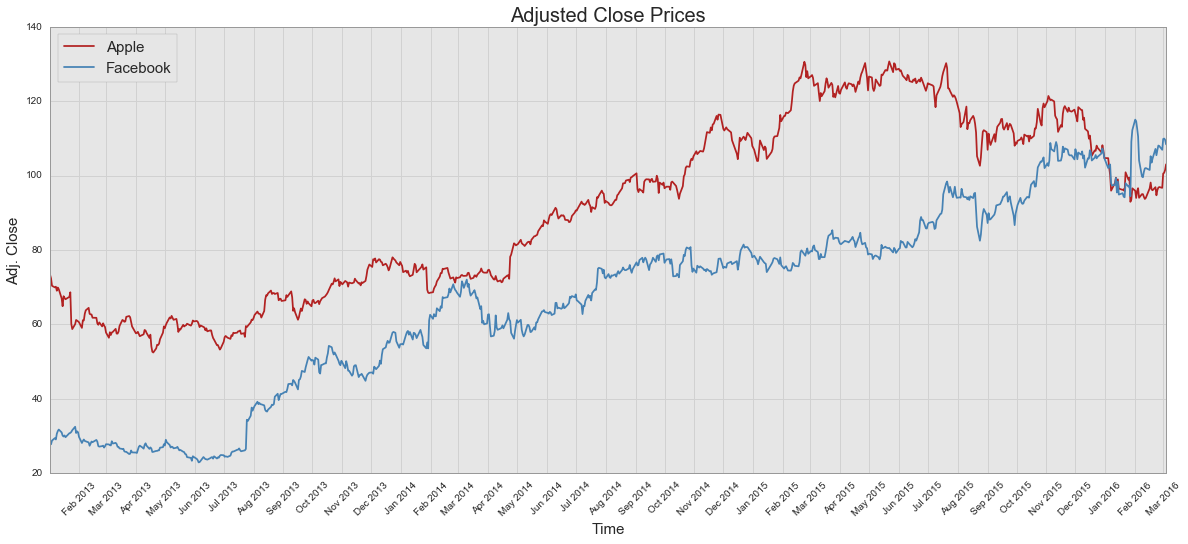

In [6]:
plot_stocks(tech.index, 
            [tech['AAPL'], tech['FB']], 
            ['Apple', 'Facebook'], 
            label_annually=False)

It is important to look at the detrended data to identify any autocorrelation structure in the series. A common approach to detrending data is taking a differences of your series until it becomes [stationary](https://en.wikipedia.org/wiki/Stationary_process). 

In [7]:
def get_lagged_series(series, order=1, log=False):
    lagged = None
    if log:
        lagged = np.log(series).diff(order).dropna();
    else:
        lagged = series.diff(order).dropna();
    
    return lagged

In [9]:
def plot_lagged_series(series, order=1, log=False):
    """
    Plots lagged series
    
    Args:
        series (ndarray): time series
        order (int): the order of the difference
        log (boolean): whether to log transform before difference
    
    Returns (None): plots inline
    """
    plt.figure(figsize=(8,4));
    plt.xlabel('Time Index');
    plt.ylabel('Difference');
    
    if log:
        plt.title('Log Series Lagged by ' + str(order));
        lagged = get_lagged_series(series, order, log)
    else:
        plt.title('Series Lagged by ' + str(order));
        lagged = get_lagged_series(series, order, log)
        
    plt.plot(np.arange(0,lagged.size,1), lagged);

#### Explore Facebook

The series seems to be approximatley stationary after a first difference, but there is some unequal variance which we can address with a log transformation.

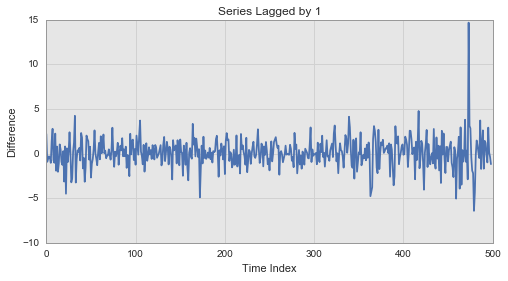

In [11]:
plot_lagged_series(tech.ix[-500:, 'FB'])

Plotting the autocorrelations and partial autocorrelations in the log of Facebook's prices over the past 500 trading days :

In [32]:
def plot_correlograms(series, limit=50):
    fig = plt.figure(figsize=(12,6));
    ax1 = fig.add_subplot(211);
    fig = sm.graphics.tsa.plot_acf(series, lags=limit, ax=ax1);
    plt.title('Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])
    
    ax2 = fig.add_subplot(212);
    fig = sm.graphics.tsa.plot_pacf(series, lags=limit, ax=ax2);
    plt.title('Partial Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])

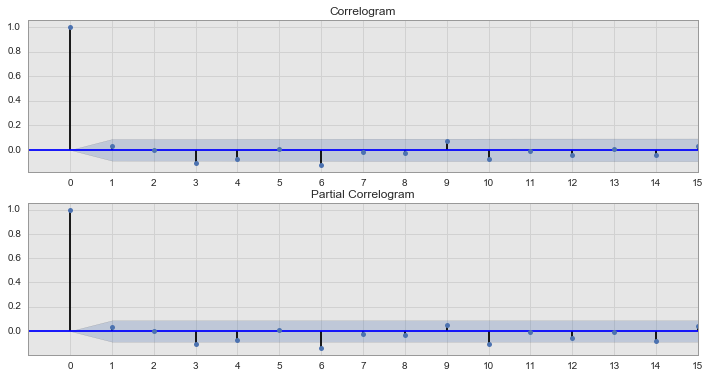

In [33]:
plot_correlograms(get_lagged_series(tech.ix[-500:, 'FB']), limit=15)

We see significant ACF and PACF values at lags 3, and 6. These are however likely due to random chance, because we are making multiple tests. Overall we see what appears to be white noise. We may be able to model this series with a random walk process.

#### Lets try the same with Apple.

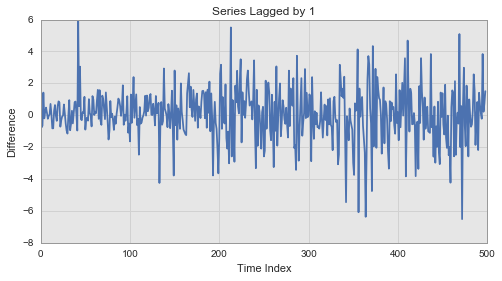

In [34]:
plot_lagged_series(tech.ix[-500:, 'AAPL'])

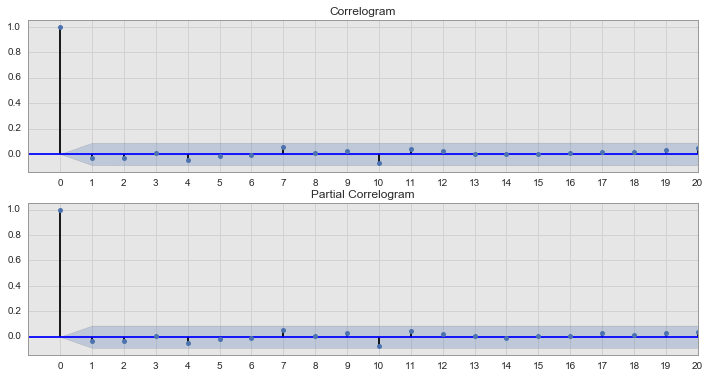

In [35]:
plot_correlograms(get_lagged_series(tech.ix[-500:, 'AAPL']), limit=20)

We see what appears to be white noise. We may be able to model this series with a random walk process.

All the plotting functions above have been copied into _viz.py_ for use in other notebooks.